# Radial Velocities
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 3/2/2022|

See JY07, Fig. 16

In [1]:
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from scipy import fftpack
from scipy.optimize import curve_fit

dpi = 300 # PDF resolution (dots per inch)
pwd = '../unstrat/'

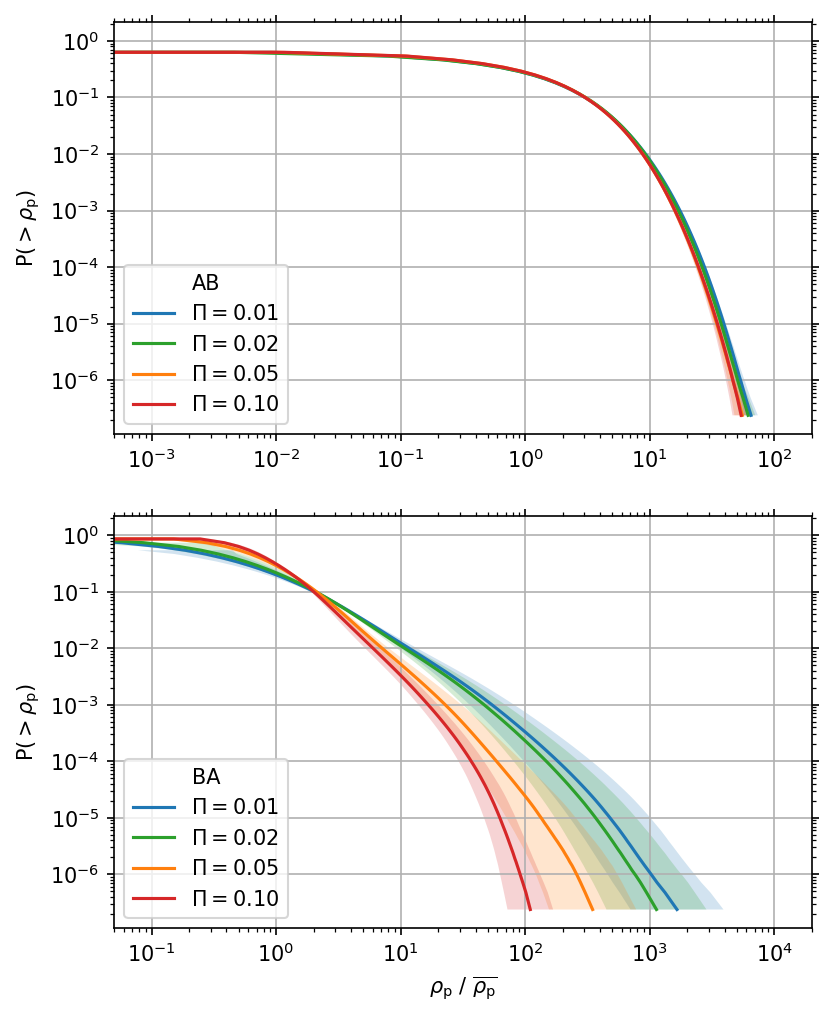

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(6,8), dpi=150)
runs = ['AB', 'BA']
Pis = [['0.01', 'tab:blue'], ['0.02', 'tab:green'],
       ['0.05', 'tab:orange'], ['0.10', 'tab:red']]
res = '2048'
xlims = [(5e-4, 2e2), (5e-2, 2e4)]
indices = -np.unique(np.logspace(np.log2(int(res)**2), 0, num=100,
                     base=2, dtype=int))
pwd = '../unstrat/'                                       # remove for final

for i,run in enumerate(runs):
    for Pi in Pis:
        with np.load(pwd+'%s/%s/%s/output/cpdd.npz'\
                     %(run, Pi[0], res)) as data:
            cdf = np.flip(np.take_along_axis(data['cdf'], indices, 0))
            avgs = np.flip(np.take_along_axis(data['avgs'], indices, 0))
            stds = np.flip(np.take_along_axis(data['stds'], indices, 0))

            axs[i].loglog(avgs, cdf, color=Pi[1], label=r'$\Pi=$'+Pi[0])
            axs[i].fill_betweenx(cdf, avgs/stds, avgs*stds, color=Pi[1],
                                 ec=None, alpha=0.2)

    axs[i].grid()
    axs[i].legend(loc='lower left', title=run)
    axs[i].minorticks_on()
    axs[i].set(xlim=xlims[i], ylabel=r'P$(>\rho_\mathrm{p})$')
    axs[i].tick_params(which='both', top=True, right=True)

axs[1].set(xlabel=r'$\rho_\mathrm{p}$ / $\overline{\rho_\mathrm{p}}$')
plt.savefig('figs/cpdd.pdf', bbox_inches='tight', pad_inches=0.01)

## Radial Dust Velocities

In [8]:
data = np.load(pwd+'AB/0.01/2048/output/vxs.npz')
data['avgs'].size

4194304

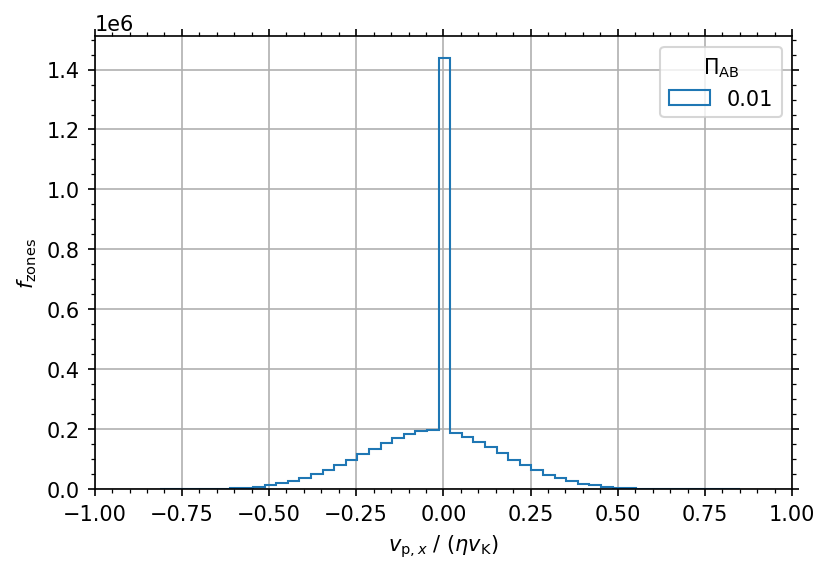

In [30]:
fig, ax = plt.subplots(dpi=150)
run = 'AB'
Pi = '0.01'
res = '2048'
n_bins = 50
xlim = (-1.0, 1.0)

path = pwd+'%s/%s/%s/'%(run, Pi, res)
athinput = athena_read.athinput(path+'athinput.si')
etav_K = float(Pi)*athinput['hydro']['iso_sound_speed']

with np.load(path+'output/vxs.npz') as data:
    vxs = data['avgs']/etav_K
    ax.hist(vxs, bins=n_bins, histtype='step', label=Pi)

ax.grid()
ax.legend(title=r'$\Pi_\mathrm{AB}$')
ax.minorticks_on()
ax.set(xlim=xlim,
    #    ylabel=r'd$f_\mathrm{p}$ / d$v_{\mathrm{p},x}$')
       ylabel=r'$f_\mathrm{zones}$')
ax.tick_params(which='both', top=True, right=True)

ax.set(xlabel=r'$v_{\mathrm{p},x}$ / $(\eta v_\mathrm{K})$')
plt.savefig('figs/cpdd.pdf', bbox_inches='tight', pad_inches=0.01)

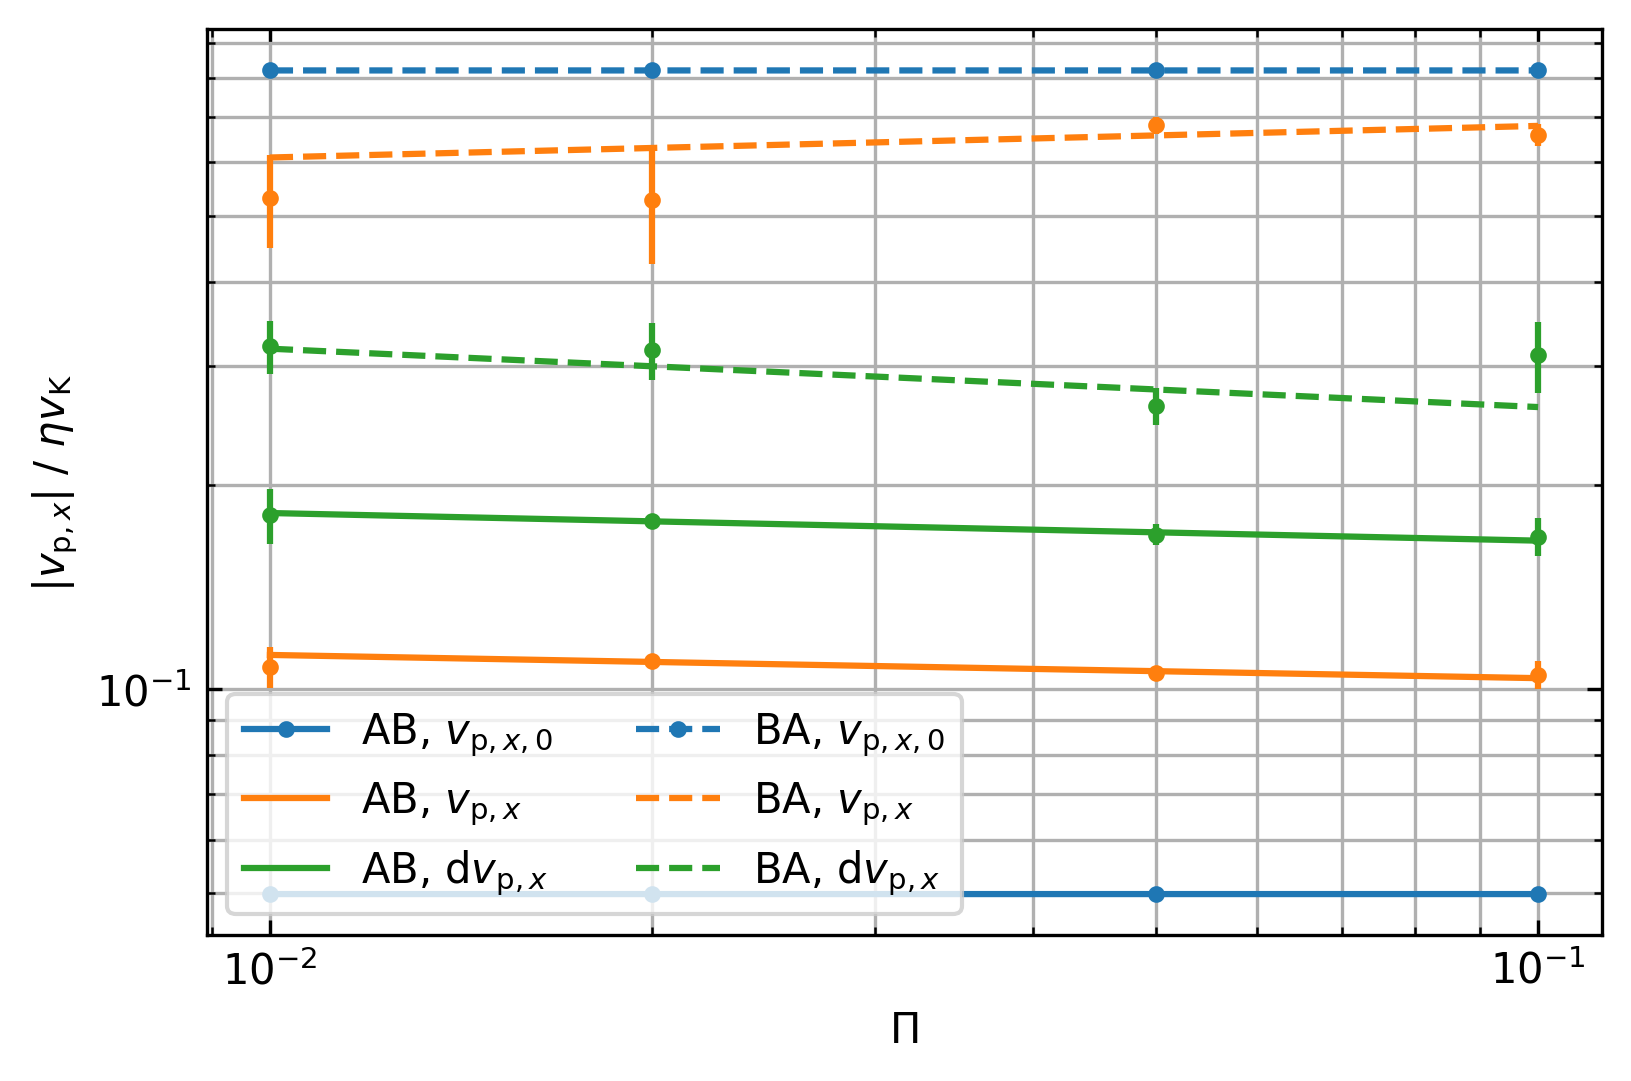

In [7]:
fig, ax = plt.subplots(dpi=dpi)
runs = [['AB', 'solid', 2.0], ['BA', 'dashed', 20.0]]
Pis = [0.01, 0.02, 0.05, 0.10]
res = '2048'
vxs0    = np.zeros((len(runs), len(Pis))) # init. velocities
vxs     = np.zeros((len(runs), len(Pis))) # sat. velocities
stdvxs  = np.zeros((len(runs), len(Pis)))
dvxs    = np.zeros((len(runs), len(Pis))) # vel. dispersion
stddvxs = np.zeros((len(runs), len(Pis))) 
case, modfunc, a, aerr, k, kerr = [], [], [], [], [], []

for i,run in enumerate(runs):
    for j,Pi in enumerate(Pis):
        path = pwd+'%s/%s/%s/'%(run[0], f'{Pi:0.2f}', res)
        athinput = athena_read.athinput(path+'athinput.si')
        hst = athena_read.hst(path+'output/SI.hst')
        i_sat = int(run[2]/athinput['output3']['dt']) # sat. state index
        prob, mesh = athinput['problem'], athinput['mesh']
        Np = prob['npx1']*prob['npx2']*prob['npx3']   # total particles
        Lx = (mesh['x1max'] - mesh['x1min'])
        Ly = (mesh['x3max'] - mesh['x3min'])
        Lz = (mesh['x2max'] - mesh['x2min'])
        V = Lx*Ly*Lz                                  # domain volume / H^3
        epsilon = prob['epsilon']
        etav_K = Pi*athinput['hydro']['iso_sound_speed']
        vxs0[i,j] = hst['vp1'][0]/etav_K/Np
        vxs[i,j] = np.average(hst['vp1'][i_sat:])/etav_K/Np
        stdvxs[i,j] = np.std(hst['vp1'][i_sat:])/etav_K/Np
        disp = np.sqrt(hst['dvpx2']/epsilon/V - (hst['dvpx']/epsilon/V)**2)
        dvxs[i,j] = np.average(disp[i_sat:])/etav_K
        stddvxs[i,j] = np.std(disp[i_sat:])/etav_K
    func = lambda x, a, k : a*x**k # power-law model function
    absvxs, absdvxs = np.abs(vxs[i,:]), np.abs(dvxs[i,:])
    popt, pcov = curve_fit(func, Pis, absvxs, sigma=stdvxs[i,:])
    poptd, pcovd = curve_fit(func, Pis, absdvxs, sigma=stddvxs[i,:])
    perr = np.sqrt(np.diag(pcov))
    perrd = np.sqrt(np.diag(pcovd))
    ax.plot(Pis, np.abs(vxs0[i,:]), marker='.', ls=run[1], color='tab:blue',
            label=run[0]+r', $v_{\mathrm{p},x,0}$')
    ax.errorbar(Pis, absvxs, stdvxs[i,:], fmt='.', color='tab:orange')
    ax.errorbar(Pis, absdvxs, stddvxs[i,:], fmt='.', color='tab:green')
    ax.plot(Pis, func(Pis, *popt), ls=run[1], color='tab:orange',
            label=run[0]+r', $v_{\mathrm{p},x}$')
    ax.plot(Pis, func(Pis, *poptd), ls=run[1], color='tab:green',
            label=run[0]+r', $\mathrm{d}v_{\mathrm{p},x}$')
    case.append(run[0]); modfunc.append(r'$|v_{\mathrm{p},x,0}|=a\Pi^k$')
    a.append(np.abs(vxs0[i,0])); aerr.append(0)
    k.append(0); kerr.append(0)
    case.append(run[0]); modfunc.append(r'$|v_{\mathrm{p},x}|=a\Pi^k$')
    a.append(popt[0]); aerr.append(perr[0])
    k.append(popt[1]); kerr.append(perr[1])
    case.append(run[0]); modfunc.append(r'$\mathrm{d}v_{\mathrm{p},x}=a\Pi^k$')
    a.append(poptd[0]); aerr.append(perrd[0])
    k.append(poptd[1]); kerr.append(perrd[1])

ax.grid(which='both')
ax.legend(ncol=2)
ax.minorticks_on()
ax.set(xlabel=r'$\Pi$', ylabel=r'$|v_{\mathrm{p},x}|$ / $\eta v_\mathrm{K}$',
       xscale='log', yscale='log')#, ylim=(5e-3, 2e0))
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
plt.savefig('figs/vxs.pdf', bbox_inches='tight', pad_inches=0.01)

df = pd.DataFrame({
    'Case'       : case,
    'Function'   : modfunc,
    '$a$'        : a,
    '$\sigma_a$' : aerr,
    '$k$'        : k,
    '$\sigma_k$' : kerr,})
s = df.style.format({
    '$a$'        : '{:.2f}',
    '$\sigma_a$' : '{:.2f}',
    '$k$'        : '{:.2f}',
    '$\sigma_k$' : '{:.2f}',})
s.to_latex(buf='tabs/vxs.txt')